# Machine Learning Project - Credit Card Fraud Detection
# Introduction
It is imperative that credit card companies possess the capability to accurately identify fraudulent credit card transactions, thereby ensuring that customers are not subjected to charges for products they have not procured. The present study aims to develop a machine learning model that utilises this data set to predict fraudulent transactions with a high degree of accuracy.


1. [Load and Check Data](#1)
2. [Variable Description](#2)
3. [Visualization](#3)
    * [Correlation Between Features](#4)
    * [Distribution Analysis](#5)
    * [Time-Based Analysis](#6)
    * [Transactions Amaunt](#7)
4. [Processing Data](#8)
    * [Scaling](#9)
    * [Splitting Data](#10)
5. [Predictive Models](#11)
    * [RandomForestClassifier](#12)
    * [AdaBoostClassifier](#13)
    * [CatBoostClassifier](#14)
    * [XGBoost](#15)
    * [LightGBM](#16)
6. [Conclusion](#17)

In [92]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from lightgbm.callback import log_evaluation
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

from collections import Counter 

RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


<a id = "1"></a><br>
# Load and Check Data

In [2]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.369007e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.500885e-15,-5.620335e-16,1.149614e-16,-2.426963e-15,...,1.596686e-16,-3.576577e-16,2.650499e-16,4.472317e-15,5.109395e-16,1.686100e-15,-3.662399e-16,-1.225457e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

<a id = "2"></a><br>
# Variable Description

1. Time: Time elapsed since the first operation (in seconds)
2. Amount: Transaction amount (currency not specified)
3. V1-V28: PCA transformed features
4. Class: 0 = Normal, 1 = Fraud

PCA (Principal Component Analysis) is a technique for reducing the dimensionality of data while preserving important patterns. It transforms correlated variables into a smaller set of uncorrelated components. This helps in removing noise, improving efficiency, and visualizing high-dimensional data.

# Missing Value

In [8]:
#columns have missing values
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

There is no missing value.

<a id = "3"></a><br>
# Visualization

<a id = "4"></a><br>
## Correlation Between Features

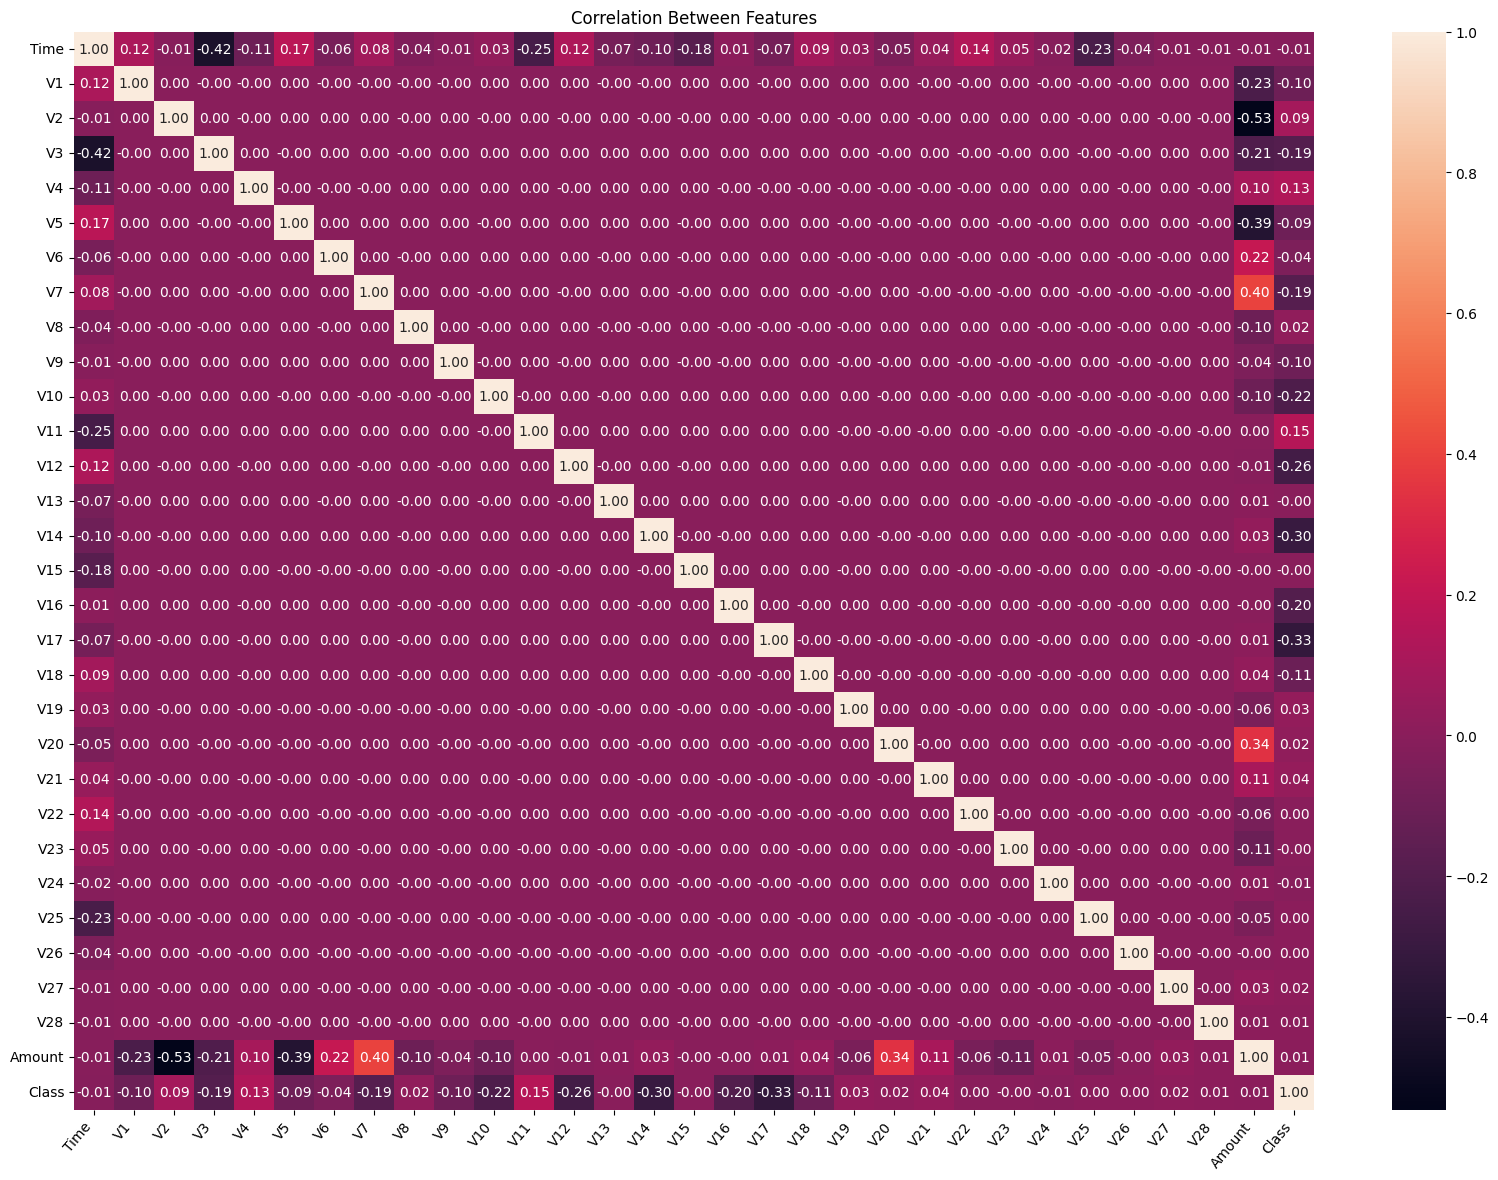

In [9]:
numeric_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(20, 14))
sns.heatmap(df[numeric_cols].corr(), annot = True, fmt = ".2f")
plt.title('Correlation Between Features')
plt.xticks(rotation= 50, ha = 'right')
plt.show()

Some features show specific correlations with Time (an inverse correlation with V3) and Amount (a direct correlation with V7 and V20, and an inverse correlation with V1 and V5).

Let’s plot both the positively and negatively correlated values on the same graph.

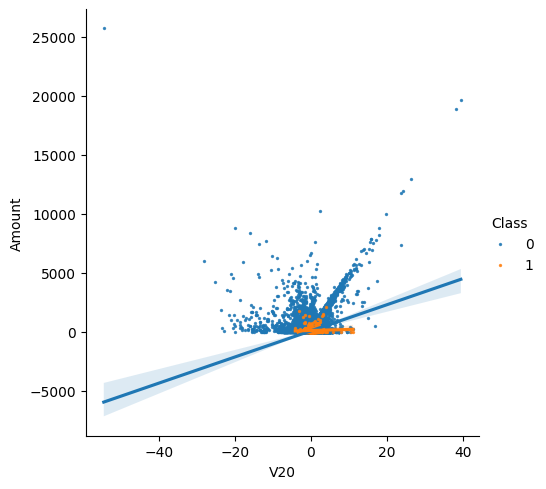

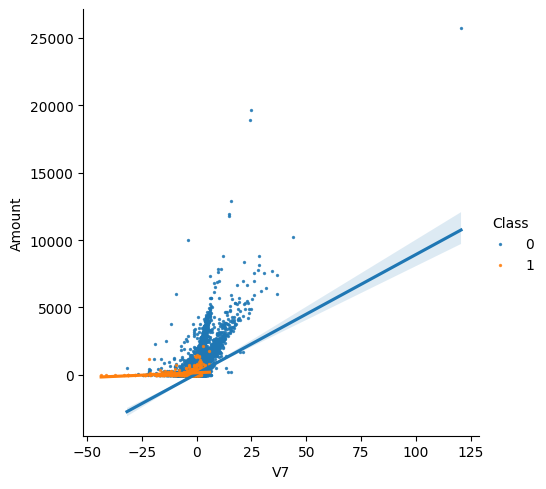

In [10]:
# Amount-V20 Amount-V7
s = sns.lmplot(x='V20', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

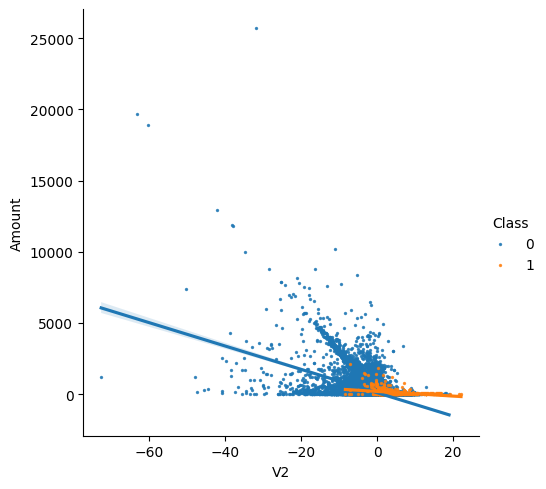

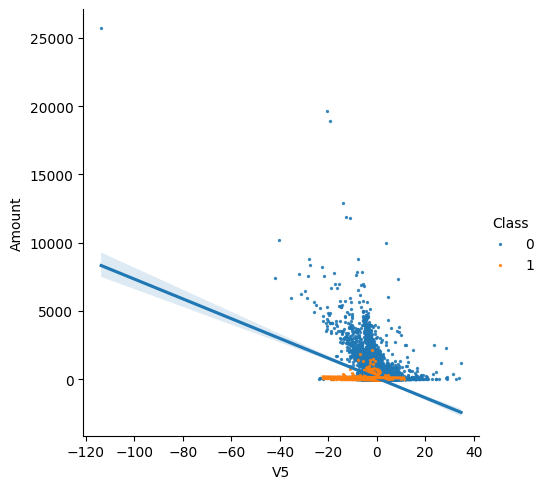

In [11]:
# Amount-V2 Amount-V5
s = sns.lmplot(x='V2', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2}) 
s = sns.lmplot(x='V5', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

<a id = "5"></a><br>
## Distribution Analysis

### Data Unbalance

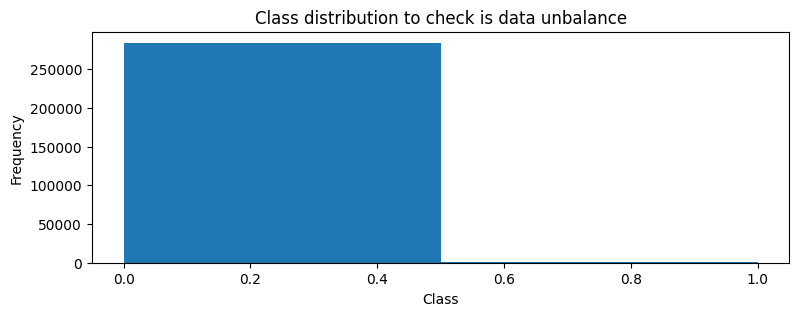

In [12]:
plt.figure(figsize = (9,3))
plt.hist(df['Class'], bins = 2)
plt.xlabel('Class')
plt.ylabel("Frequency")
plt.title("Class distribution to check is data unbalance")
plt.show()

In [13]:
print ("Fraud")
print (df.Time[df.Class == 1].describe(), "\n")
print ("Normal")
print (df.Time[df.Class == 0].describe())
# print ("\nFraud",
#       "\n", df.Time[df.Class == 1].describe(),
#       "\nNormal",
#       "\n", df.Time[df.Class == 0].describe())

Fraud
count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64 

Normal
count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64


A few of transactions are fraud. That means data is unbalanced.

### Histogram Plots Excluding Class

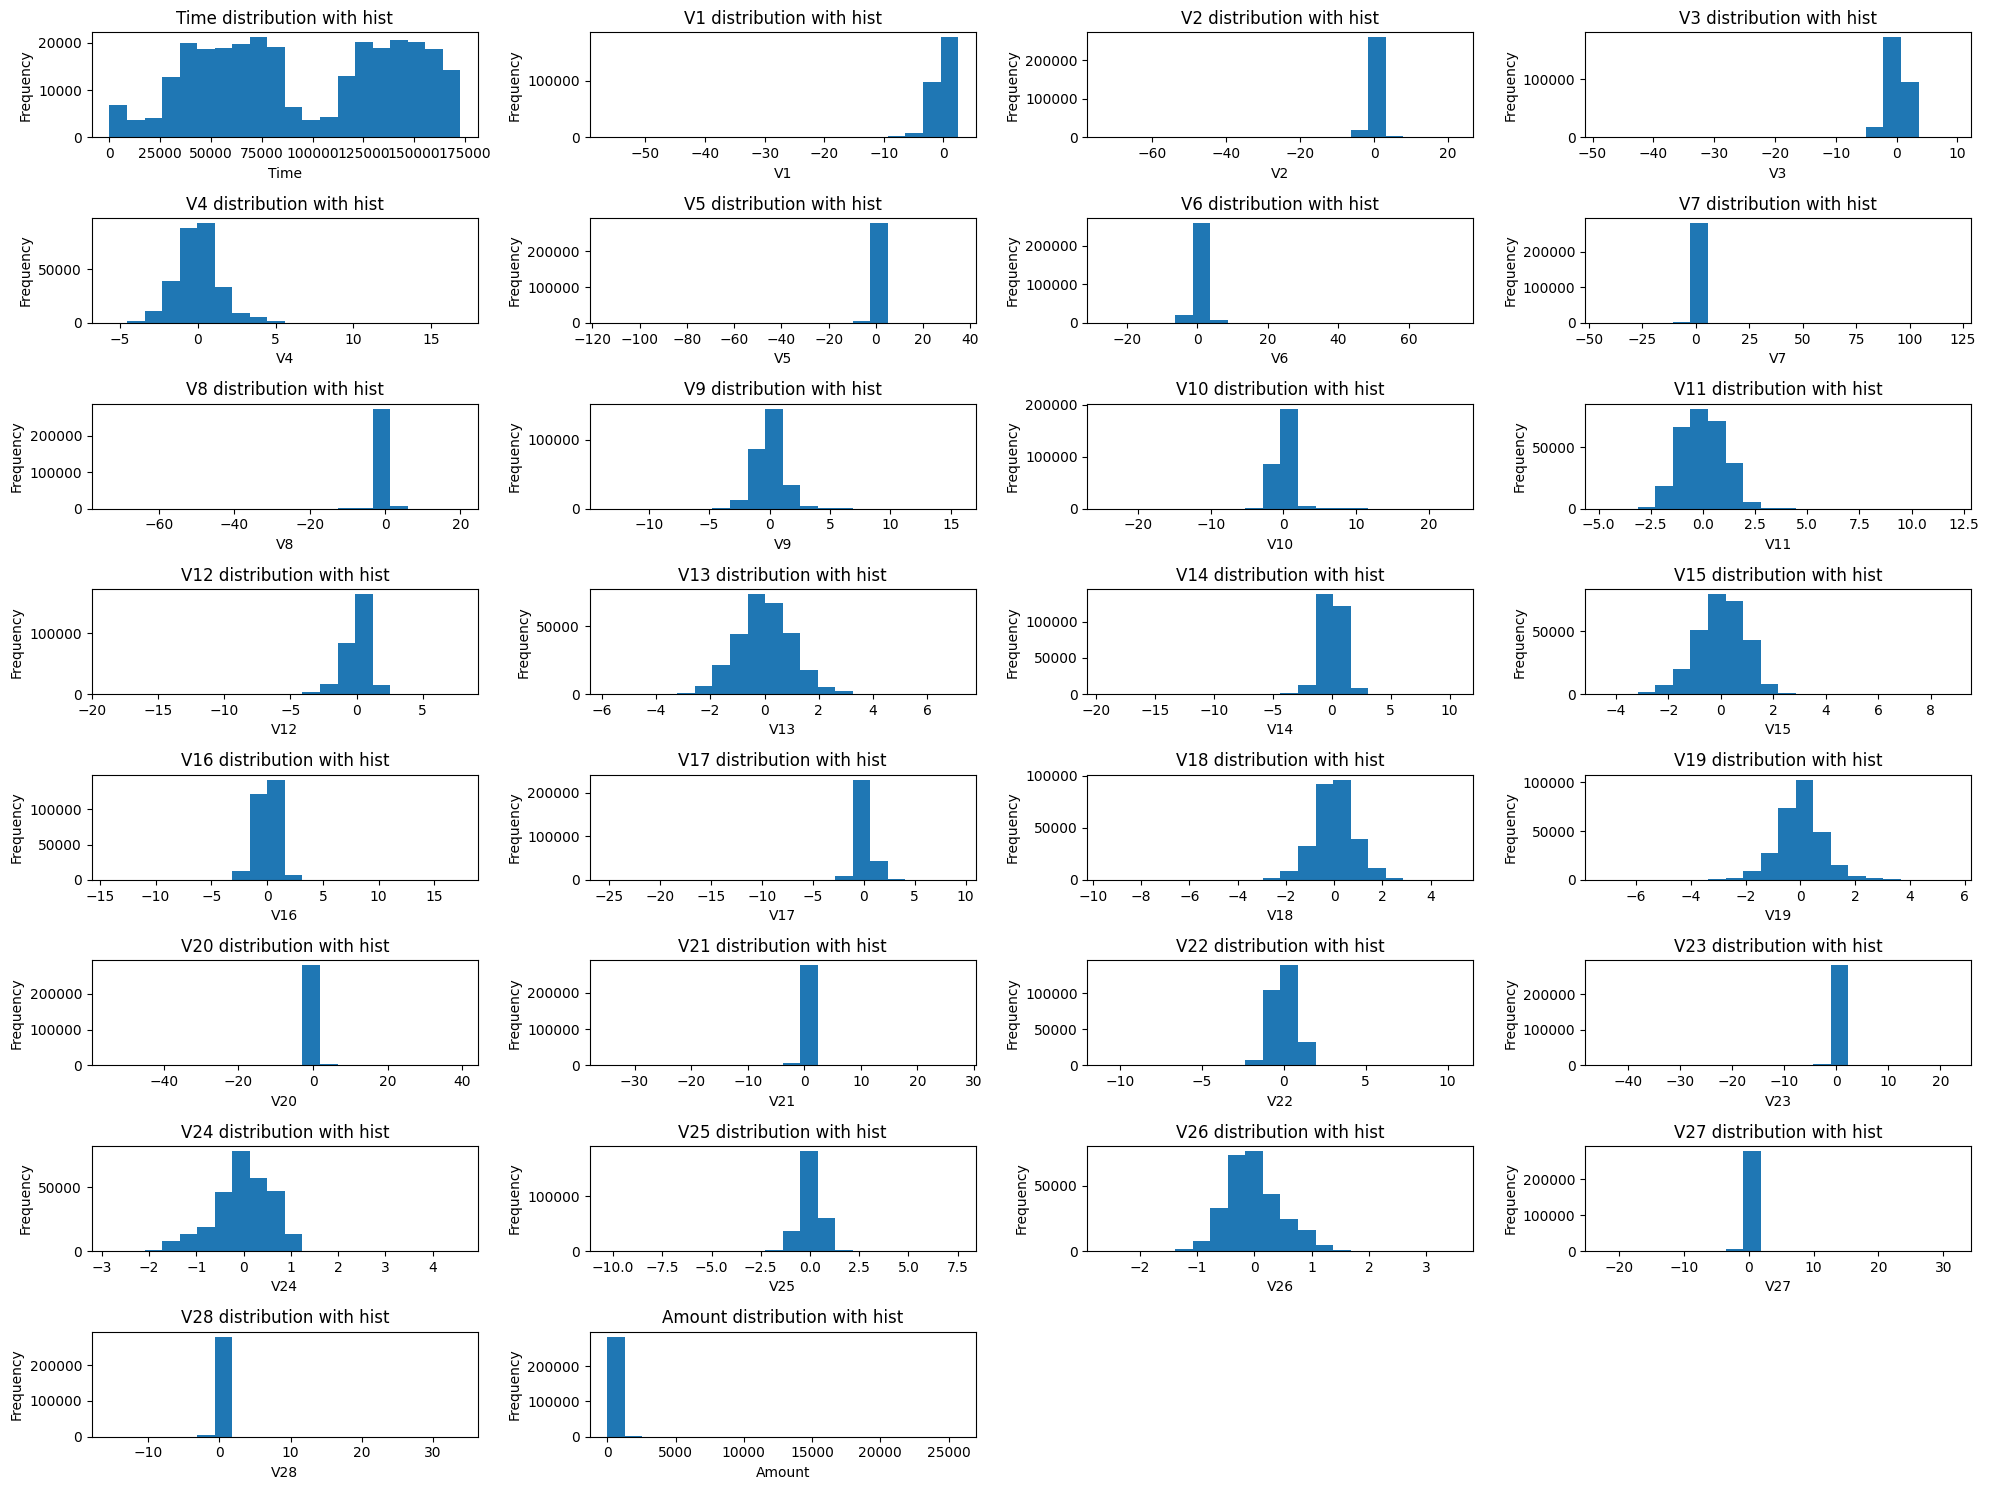

In [14]:
Vars = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

plt.figure(figsize=(20, 15))
for i, var in enumerate(Vars):
    plt.subplot(len(Vars)//4 + 1, 4, i+1)
    plt.hist(df[var], bins=20)
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.title(f"{var} distribution with hist")
plt.tight_layout()
plt.show()

### Histogram Plots Excluding Class (when Class = 1)

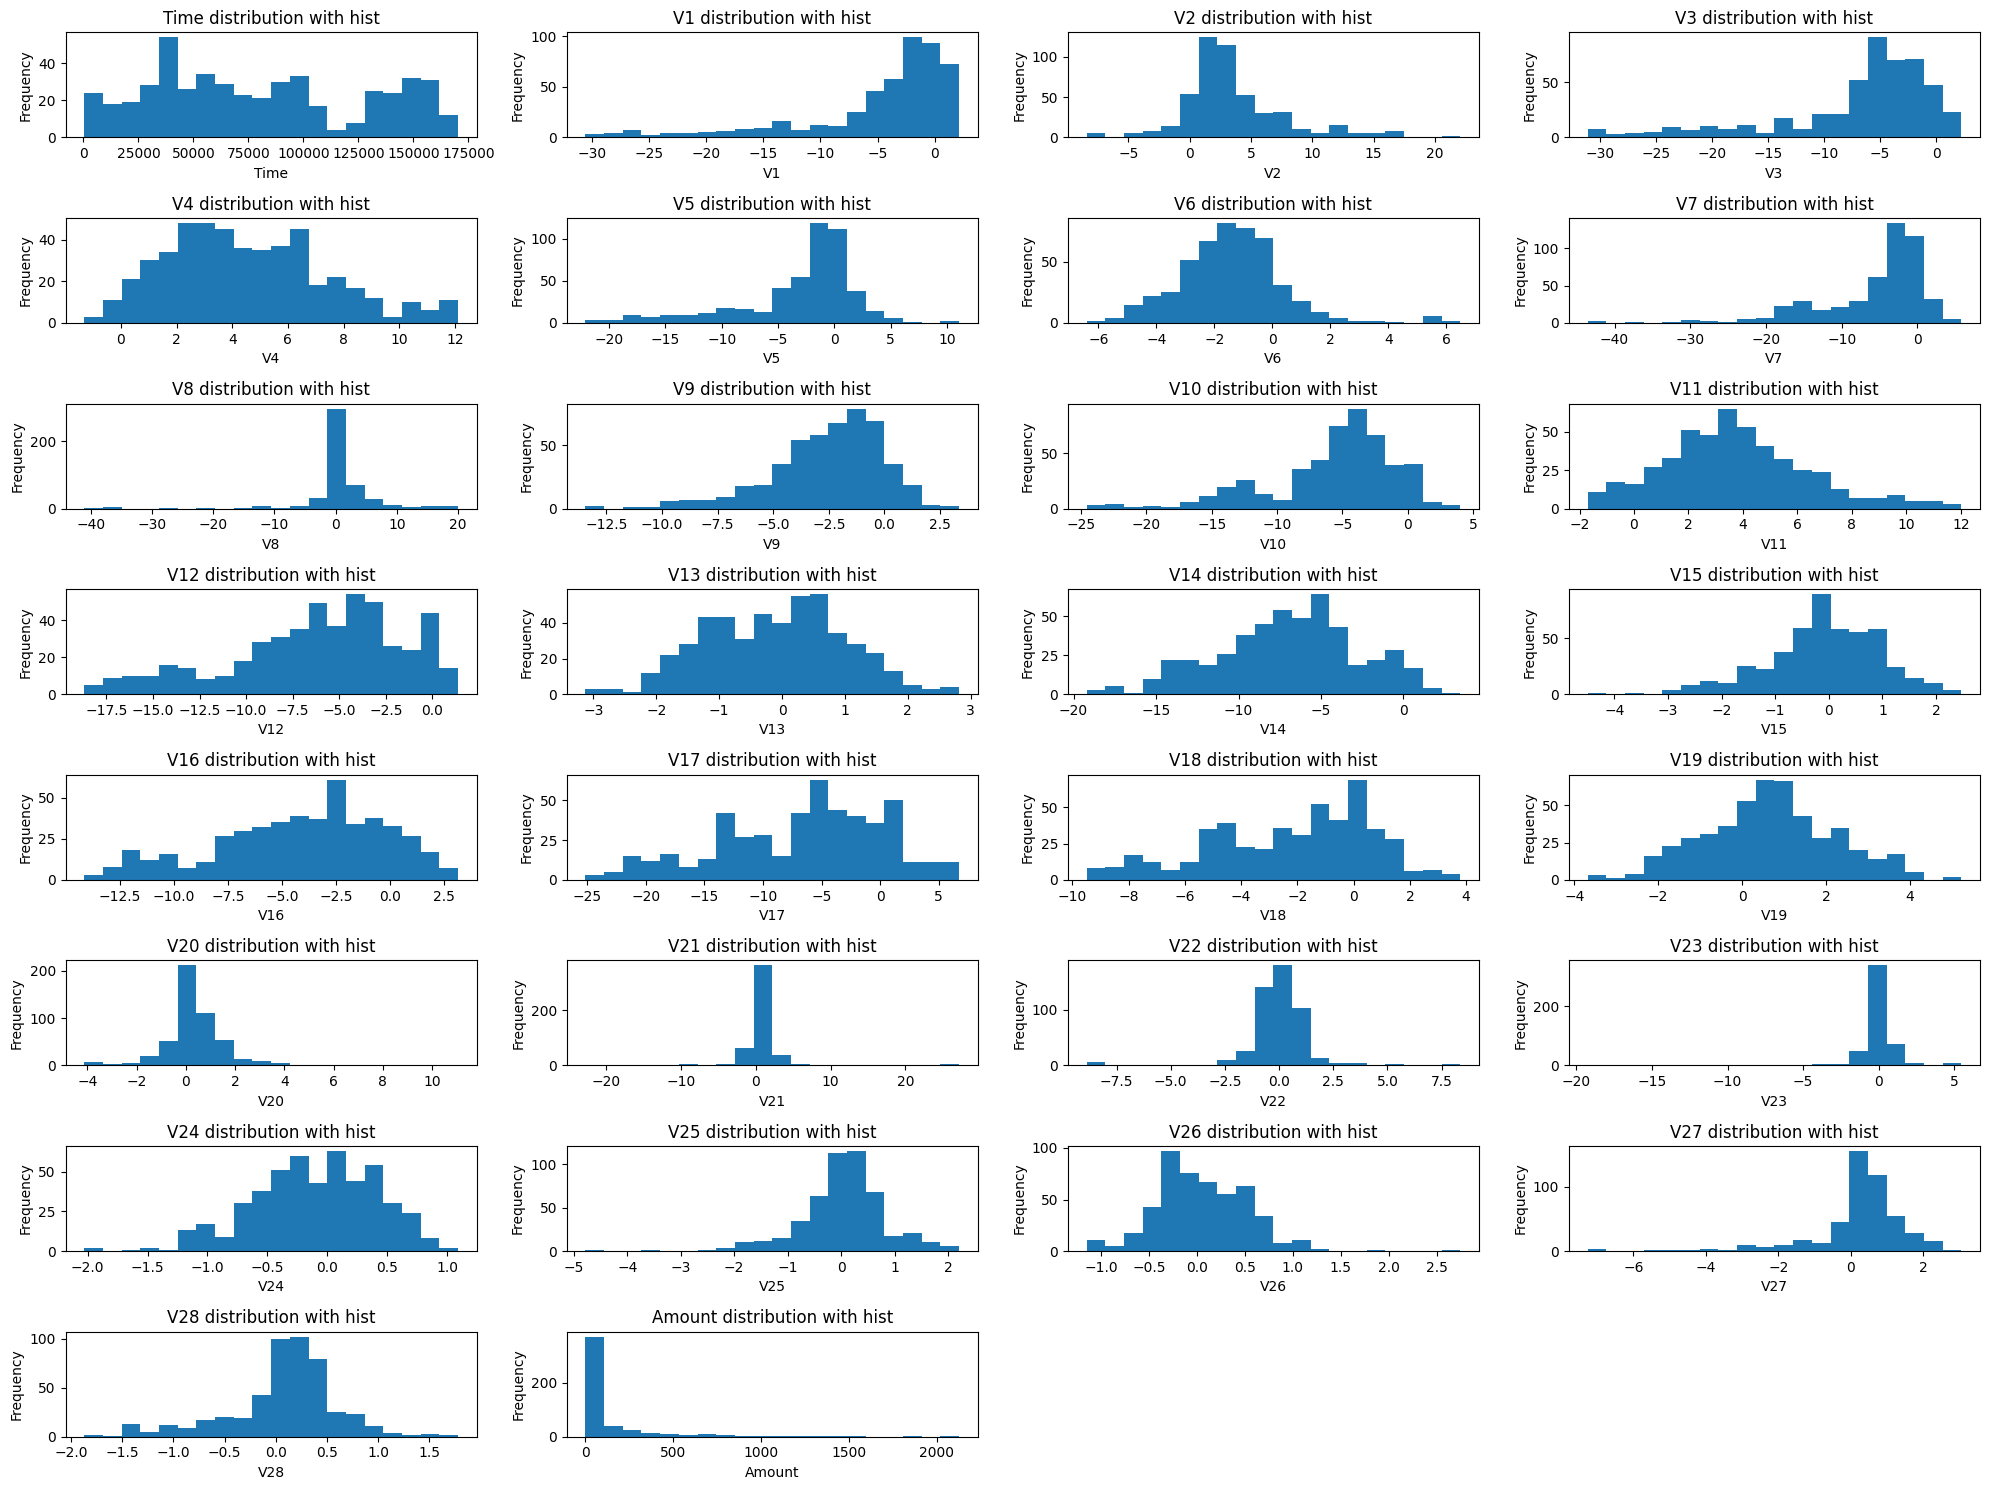

In [15]:
filtered_df = df[df['Class'] == 1]

plt.figure(figsize=(20, 15))
for i, var in enumerate(Vars):
    plt.subplot(len(Vars)//4 + 1, 4, i+1)
    plt.hist(filtered_df[var], bins=20)
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.title(f"{var} distribution with hist")
plt.tight_layout()
plt.show()

Let's draw a KDE plot to compare these graphs more easily.

<Figure size 640x480 with 0 Axes>

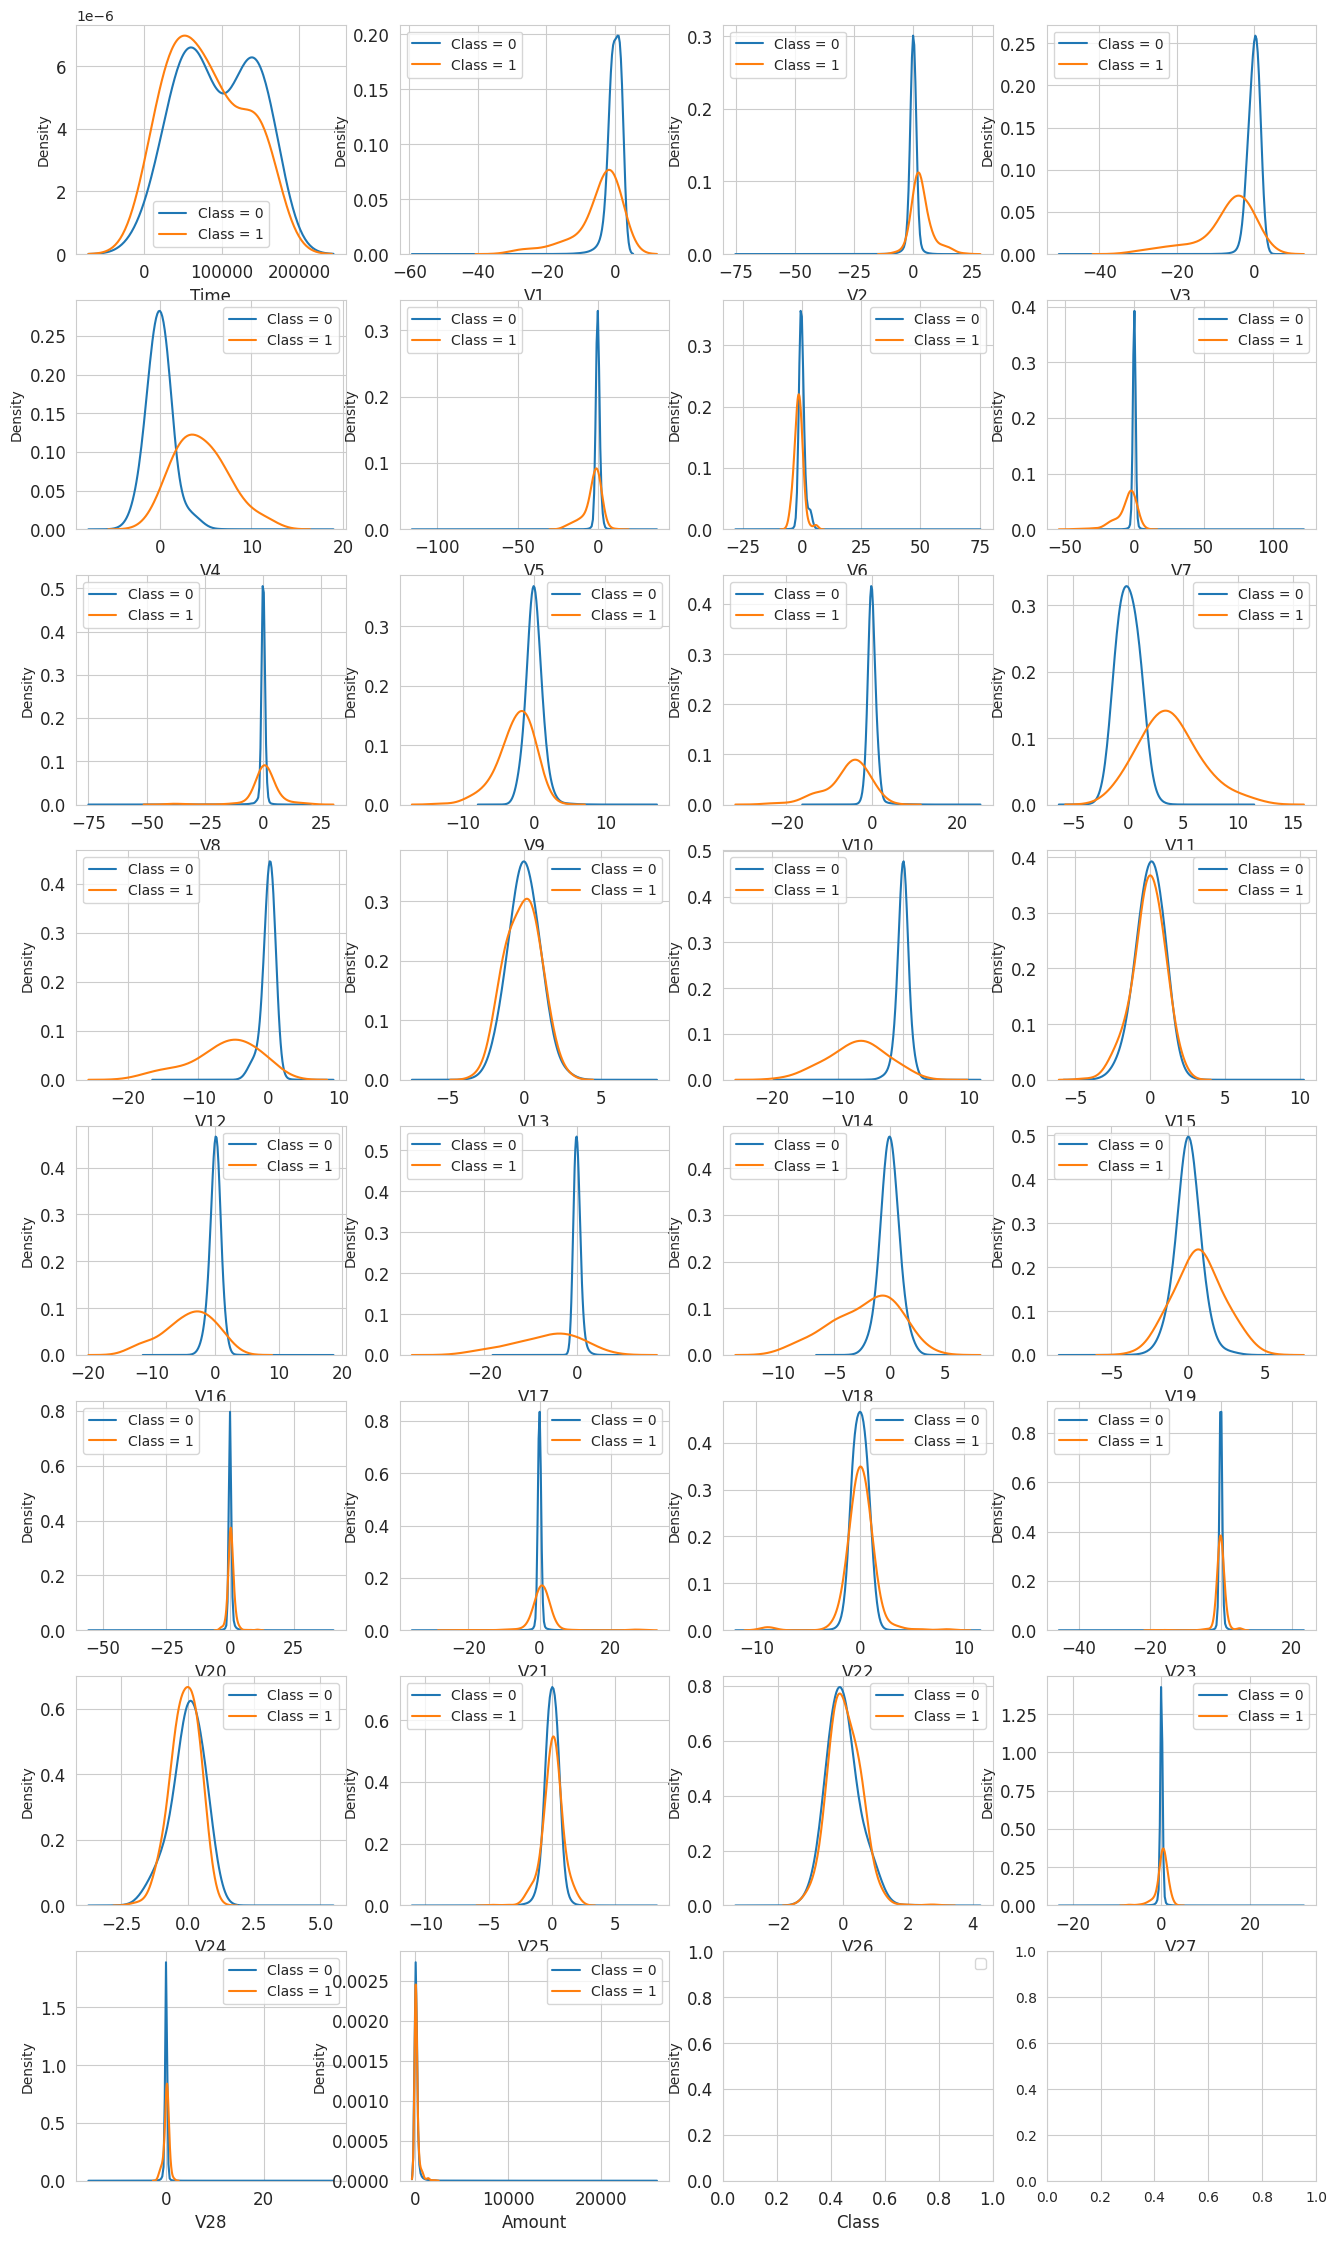

In [16]:
var = df.columns.values

i = 0
t0 = df.loc[df['Class'] == 0]
t1 = df.loc[df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend()
plt.show()

* According to the plots above, normal transactions seem to be concentrated around 0.
* Some features are easily selective like V4, V11 and some features are selective V12, V14, V18.

<a id = "6"></a><br>
## Time-Based Analysis

In [17]:
df['Time'].dtype

dtype('float64')

In [18]:
class_0 = df.loc[df['Class'] == 0]["Time"]
class_1 = df.loc[df['Class'] == 1]["Time"]

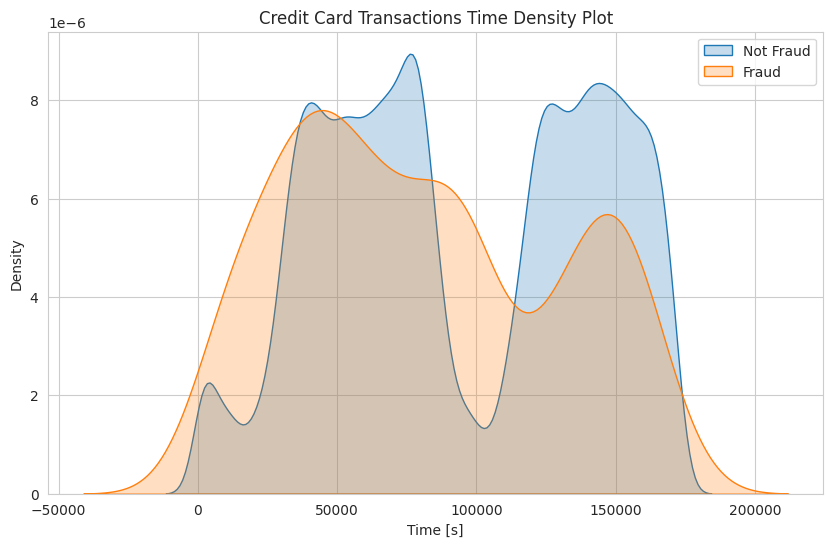

In [19]:
plt.figure(figsize=(10, 6))
sns.kdeplot(class_0, label='Not Fraud', shade=True)
sns.kdeplot(class_1, label='Fraud', shade=True)

plt.title('Credit Card Transactions Time Density Plot')
plt.xlabel('Time [s]')
plt.legend()
plt.show()

In [20]:
df['Hour'] = df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


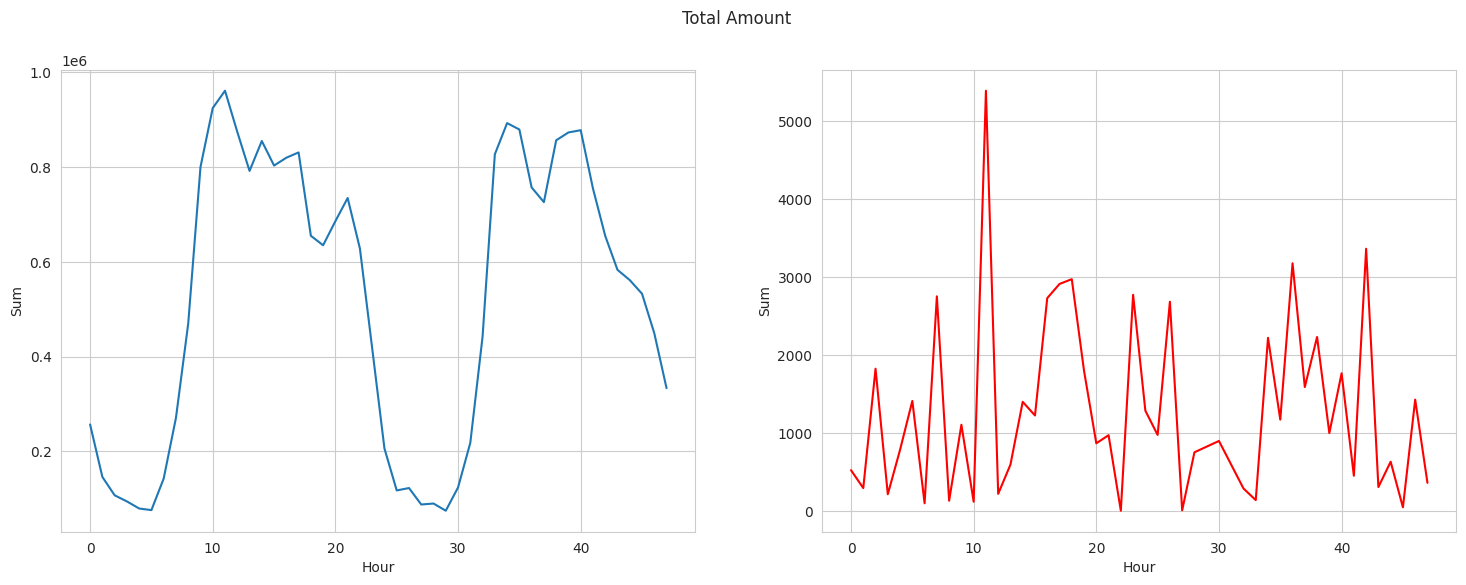

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show()

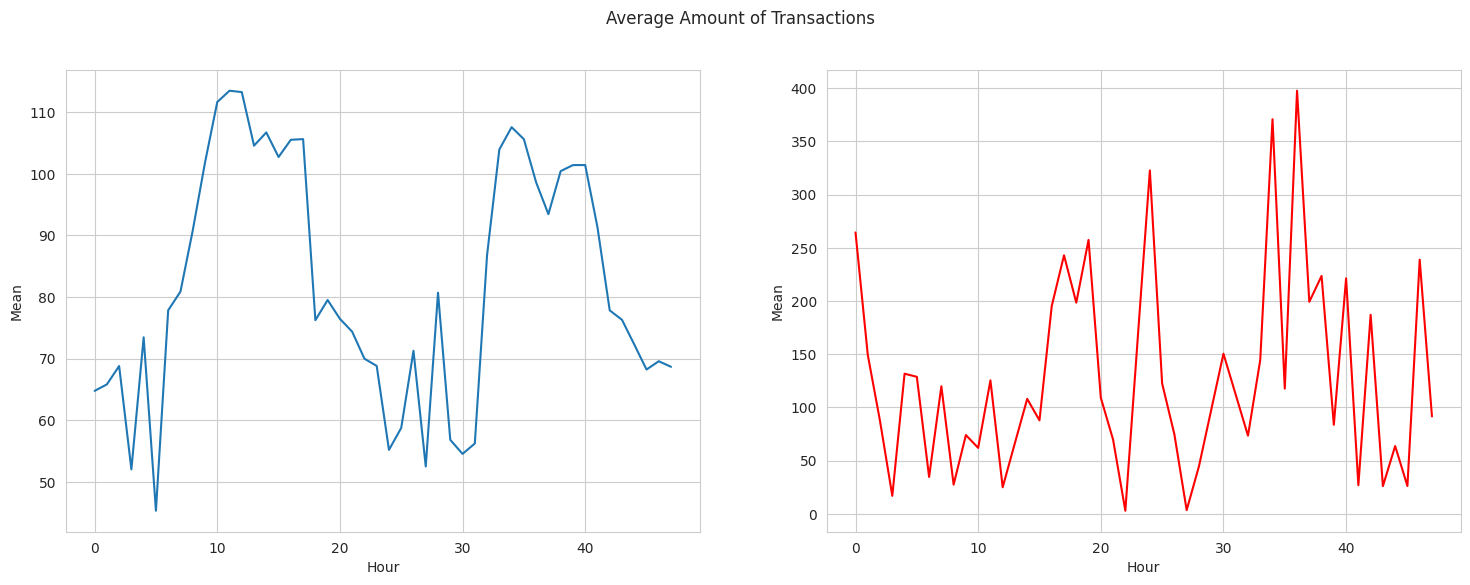

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show()

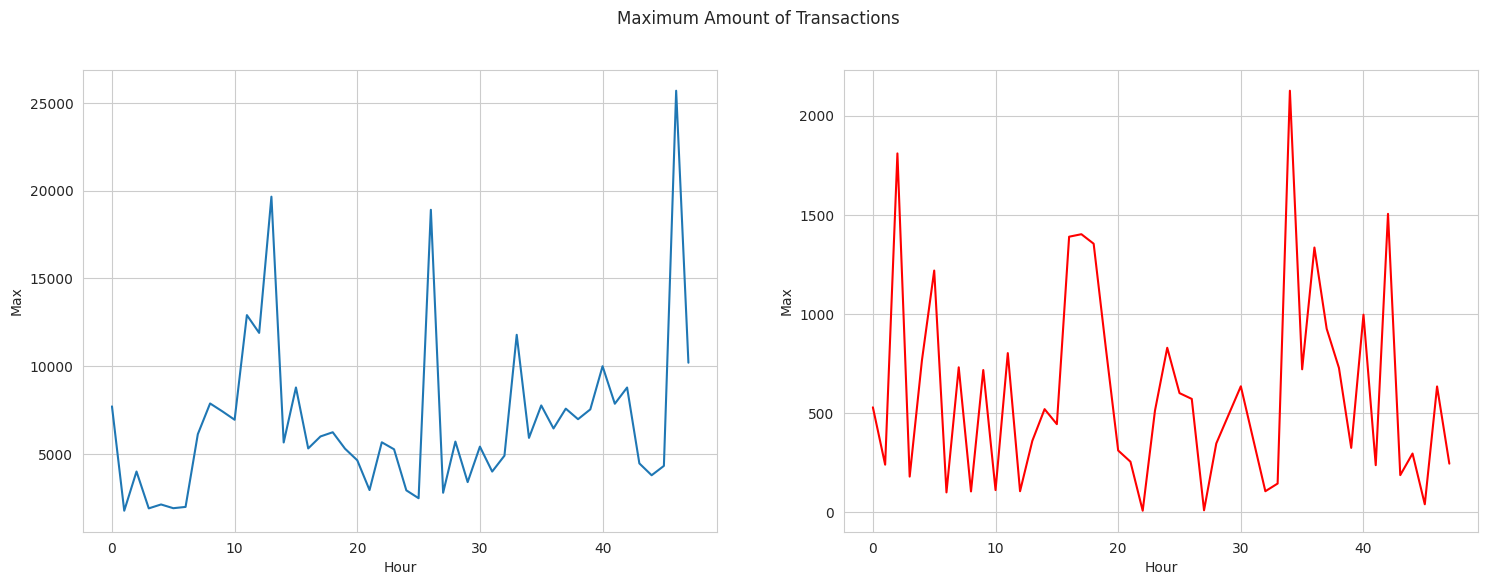

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show()

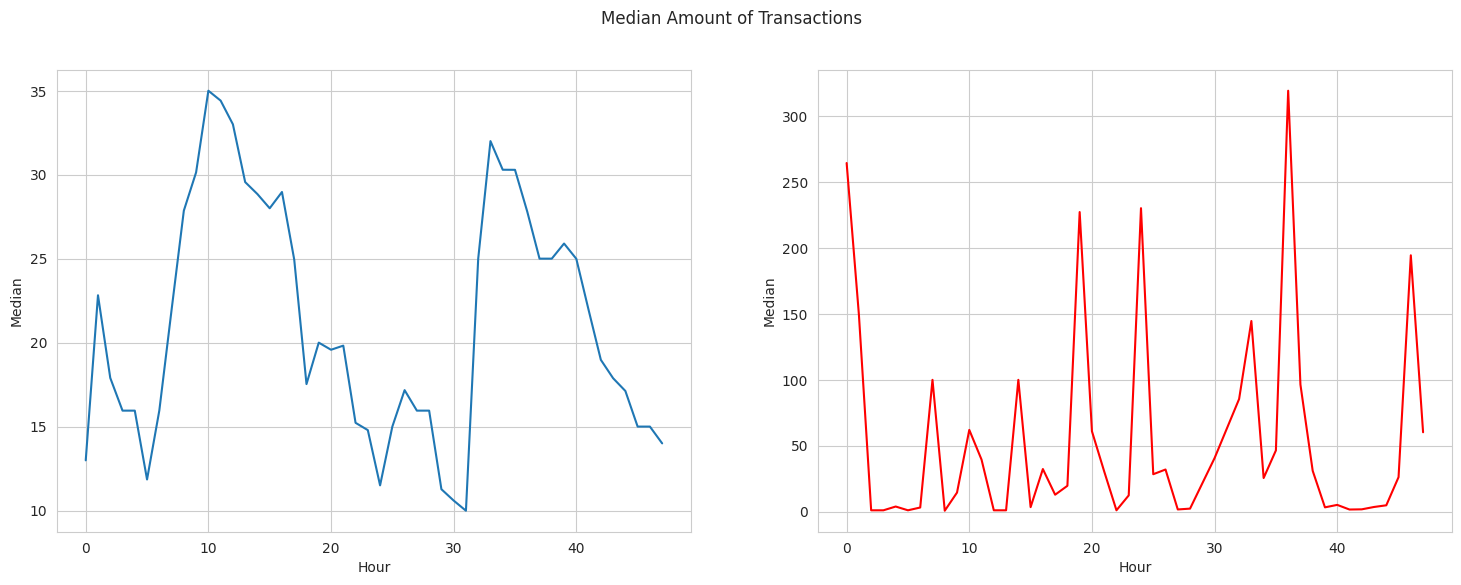

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show();

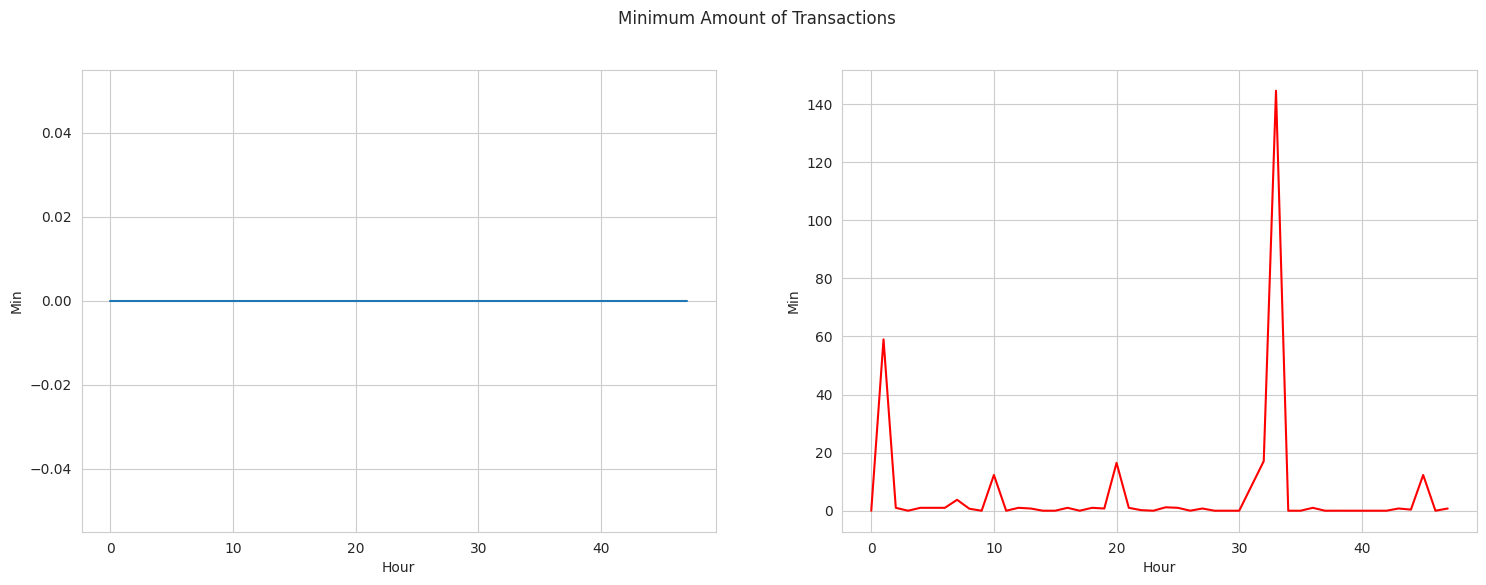

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show()

<a id = "7"></a><br>
## Transactions amount

In [27]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

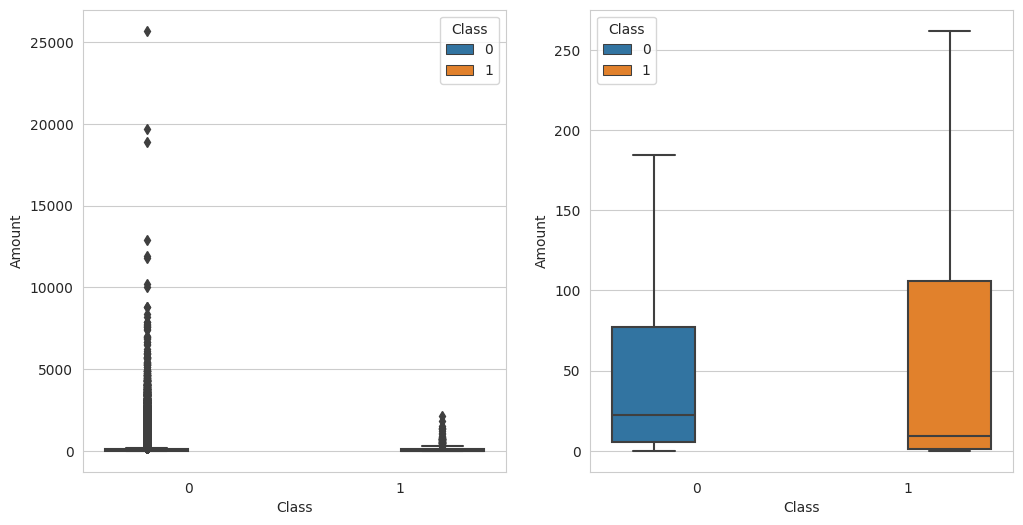

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df,showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df,showfliers=False)
plt.show();

Let's see the amount differentations between fraud and normal.

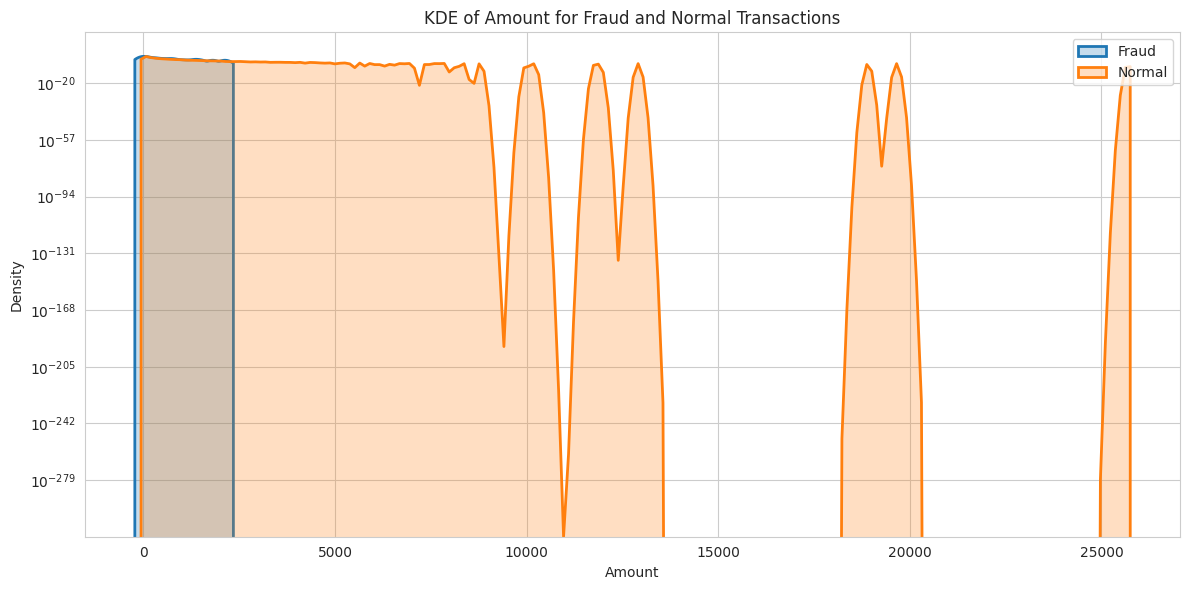

In [29]:
# Görselleştirme
plt.figure(figsize=(12, 6))

# Fraud verisi için KDE (kırmızı renk)
sns.kdeplot(df.Amount[df.Class == 1], fill=True, linewidth=2, label='Fraud')

# Normal verisi için KDE (mavi renk)
sns.kdeplot(df.Amount[df.Class == 0], fill=True, linewidth=2, label='Normal')

# Başlık ve etiketler
plt.title('KDE of Amount for Fraud and Normal Transactions')
plt.xlabel('Amount')
plt.ylabel('Density')

# Logaritmik Y ekseni
plt.yscale('log')

# Efsane (legend)
plt.legend()

plt.tight_layout()
plt.show()

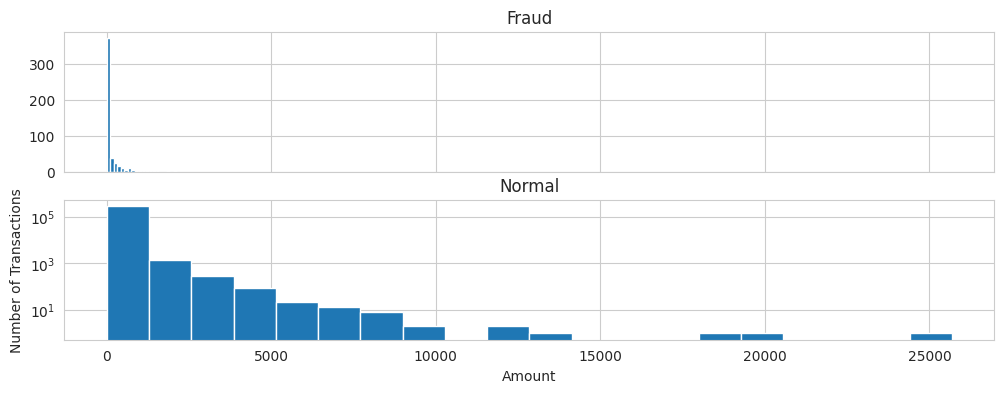

In [30]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

ax1.hist(df.Amount[df.Class == 1], bins = 20)
ax1.set_title('Fraud')

ax2.hist(df.Amount[df.Class == 0], bins = 20)
ax2.set_title('Normal')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.yscale('log') # Since the data values have a wide range, we can see a better plot when viewed logarithmically
plt.show()

<a id = "9"></a><br>
# Prepocessing Data

## Scaling

In [31]:
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler() # RobustScaler is less prone to outliers

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)


In [32]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


In [33]:
# Adjusting the position of columns
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


<a id = "10"></a><br>
## Splitting Data

This place may be redundant

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold


print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [35]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
247567,-0.244533,0.809784,-0.711894,-0.354588,1.855870,-2.099132,-0.446660,0.282577,-0.553653,0.201823,...,0.155644,0.131830,0.788428,-0.080721,-0.656112,-0.083355,-0.252563,0.329700,0.194772,0
42590,-0.233354,-0.511378,-5.932778,4.571743,-9.427247,6.577056,-6.115218,-3.661798,-10.894079,3.709210,...,1.191078,2.014272,-0.167417,0.049968,0.384430,-0.077884,0.565493,1.792012,0.371007,1
4235,0.091665,-0.950892,-7.955978,-10.773199,1.833876,0.612396,10.421778,-5.939790,-7.267740,1.148789,...,2.867380,0.648564,-1.301176,1.739646,-1.849254,0.810815,-0.484609,-0.381375,0.238919,0
74496,-0.295815,-0.341616,-7.347955,2.397041,-7.572356,5.177819,-2.854838,-1.795239,-8.783235,0.437157,...,0.073164,-0.175273,0.543325,-0.547955,-0.503722,-0.310933,-0.163986,1.197895,0.378187,1
151519,-0.284636,0.128479,-17.518909,12.572118,-19.038538,11.190895,-13.554721,-0.411924,-23.189397,-5.301412,...,2.528512,-4.969478,0.976125,1.841248,0.334418,-0.720128,-0.232603,-3.021992,-0.478158,1


In [36]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 984 entries, 247567 to 198868
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   scaled_amount  984 non-null    float64
 1   scaled_time    984 non-null    float64
 2   V1             984 non-null    float64
 3   V2             984 non-null    float64
 4   V3             984 non-null    float64
 5   V4             984 non-null    float64
 6   V5             984 non-null    float64
 7   V6             984 non-null    float64
 8   V7             984 non-null    float64
 9   V8             984 non-null    float64
 10  V9             984 non-null    float64
 11  V10            984 non-null    float64
 12  V11            984 non-null    float64
 13  V12            984 non-null    float64
 14  V13            984 non-null    float64
 15  V14            984 non-null    float64
 16  V15            984 non-null    float64
 17  V16            984 non-null    float64
 18  V17    

Distribution of the Classes in the subsample dataset
Class
0    0.5
1    0.5
Name: count, dtype: float64


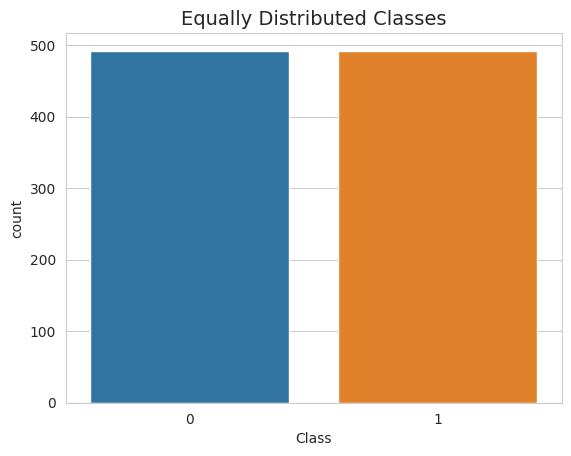

In [37]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))



sns.countplot(x='Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()


<a id = "11"></a><br>
# Predictive Models

In [61]:
def features_importance():
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (7,4))
    plt.title('Features importance',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()

def confusion_matrix():
    cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
    fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
    sns.heatmap(cm, 
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'],
                annot=True,ax=ax1,
                linewidths=.2,linecolor="Darkblue", cmap="Blues")
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()

In [38]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [39]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [40]:
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

<a id = "12"></a><br>
## RandomForestClassifier

In [41]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [42]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

Let's now predict the target values for the valid_df data, using predict function.

In [43]:
preds = clf.predict(valid_df[predictors])

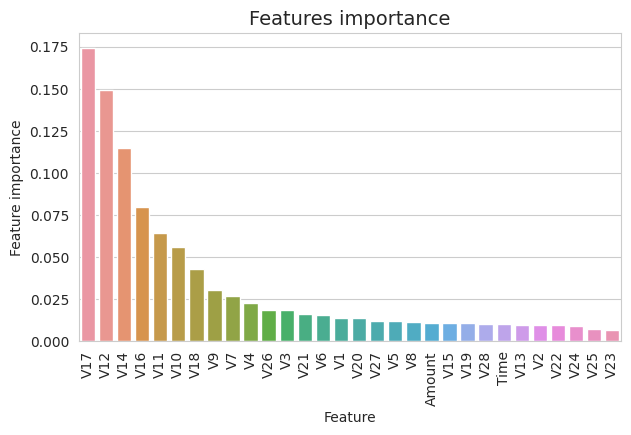

In [44]:
features_importance()  

### Confusion Matrix

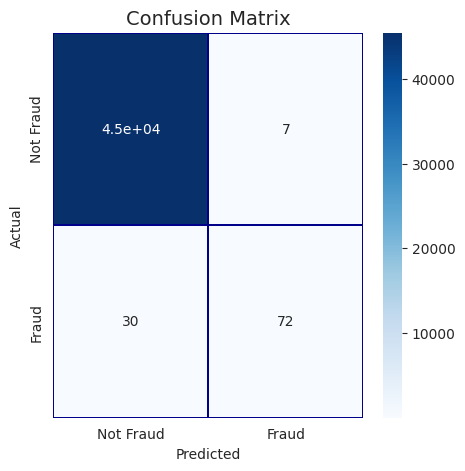

In [45]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [46]:
roc_auc_score(valid_df[target].values, preds)

0.8528641975628091

The ROC-AUC score obtained with RandomForrestClassifier is 0.85.

<a id = "13"></a><br>
## AdaBoostClassifier

In [49]:
# Prepare the model
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [50]:
# Fit the model
clf.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [51]:
# Predict the target values
preds = clf.predict(valid_df[predictors])

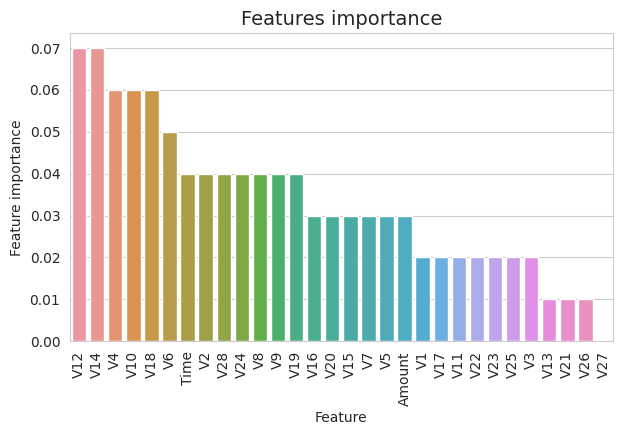

In [52]:
#Features importance
features_importance()

### Confusion Matrix

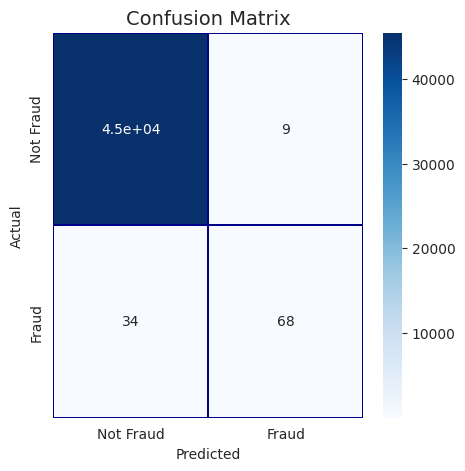

In [54]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [53]:
# Calculate ROC-AUC
roc_auc_score(valid_df[target].values, preds)

0.8332343604519027

The ROC-AUC score obtained with AdaBoostClassifier is 0.83.


<a id = "14"></a><br>
## CatBoostClassifier

In [55]:
#Prepare the model
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [57]:
# Fit the model
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 379ms	remaining: 3m 9s
50:	total: 16.1s	remaining: 2m 22s
100:	total: 31.1s	remaining: 2m 2s
150:	total: 46.2s	remaining: 1m 46s
200:	total: 1m 1s	remaining: 1m 30s
250:	total: 1m 16s	remaining: 1m 15s
300:	total: 1m 31s	remaining: 1m
350:	total: 1m 46s	remaining: 45.1s
400:	total: 2m 1s	remaining: 30s
450:	total: 2m 16s	remaining: 14.9s
499:	total: 2m 31s	remaining: 0us


In [58]:
# Predict the tagret values
preds = clf.predict(valid_df[predictors])

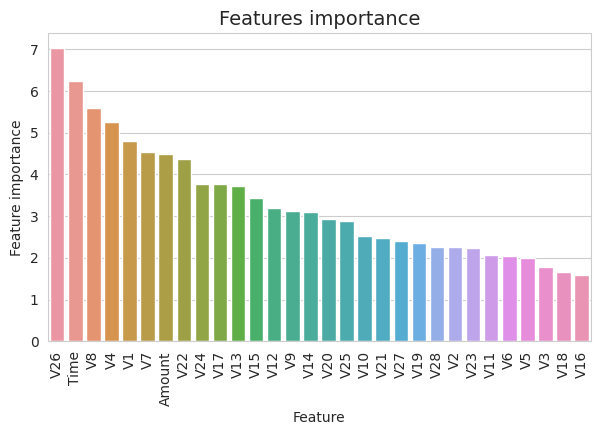

In [60]:
features_importance()

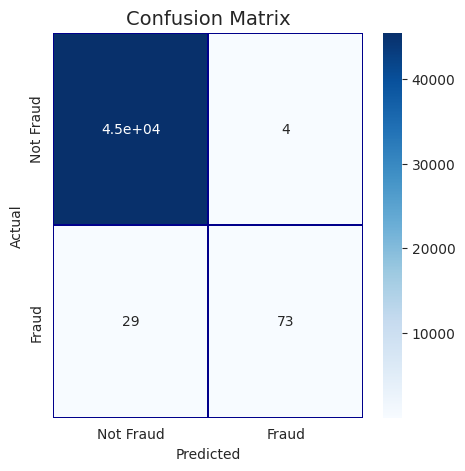

In [62]:
confusion_matrix()

In [63]:
# Calculate ROC-AUC
roc_auc_score(valid_df[target].values, preds)

0.8577991493075996

The ROC-AUC score obtained with CatBoostClassifier is 0.86

In [ ]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

<a id = "15"></a><br>
## XGBoost

In [70]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [71]:
# Train model
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.94070	valid-auc:0.88630
[50]	train-auc:0.94043	valid-auc:0.89529
[100]	train-auc:0.97414	valid-auc:0.96283
[150]	train-auc:0.98510	valid-auc:0.98126
[200]	train-auc:0.99295	valid-auc:0.98520
[250]	train-auc:0.99519	valid-auc:0.98406
[262]	train-auc:0.99567	valid-auc:0.98377


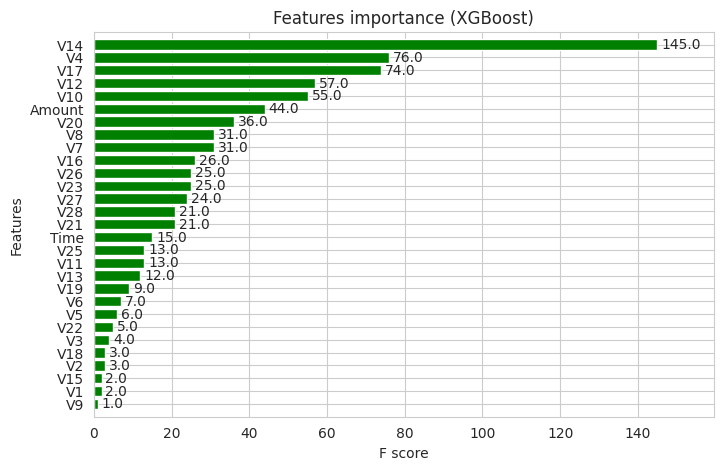

In [68]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

In [73]:
#Predict test set
preds = model.predict(dtest)

In [74]:
roc_auc_score(test_df[target].values, preds)

0.9796317400021104

The AUC score for the prediction of fresh data (test set) is 0.974.

<a id = "16"></a><br>
## LightGBM

In [87]:
# Define model parameters
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

In [88]:
# Prepare the model
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

In [95]:
# Create a dictionary to store evaluation results
evals_results = {}

# Create callback for recording evaluation results
callbacks = []

# If you have the record_evaluation function
try:
    callbacks.append(lgb.record_evaluation(evals_results))
except:
    pass  # Skip if not available

model = lgb.train(params, 
                  dtrain, 
                  num_boost_round=MAX_ROUNDS,
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'],
                  callbacks=callbacks)

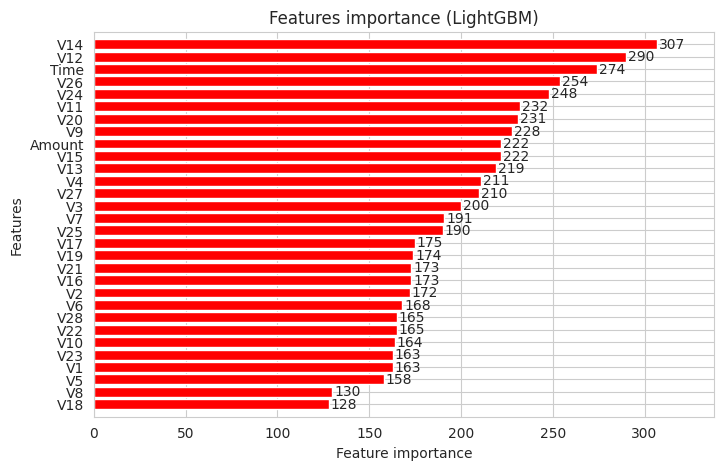

In [96]:
#plot variable importance 
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

In [97]:
preds = model.predict(test_df[predictors])

In [98]:
roc_auc_score(test_df[target].values, preds)

0.9463351623228167

<a id = "17"></a><br>
# Conclusion

The issue of dataset imbalance and its potential consequences
Dataset imbalance occurs when the distribution of target classes in a dataset is significantly skewed. To illustrate this, consider a dataset comprising 99.83% legitimate transactions and only 0.17% fraud cases. Such imbalance can give rise to several issues, including model bias. Machine learning models tend to be biased towards the majority class, as they are trained to minimise the overall error. In the context of fraud detection, the model may predict "No Fraud" for the majority of cases, as this appears to be the most "accurate" prediction given the imbalanced dataset.Poor Performance on Minority Class: Due to the infrequency of fraud cases, models may not effectively learn the characteristics of fraudulent transactions, resulting in a high false-negative rate (fraudulent transactions are classified as legitimate).Evaluation Metrics Distortion: Conventional evaluation metrics such as accuracy can be deceptive in imbalanced datasets, as a model that consistently predicts the majority class may achieve high accuracy but perform inadequately in detecting the minority class (frauds). Consequently, metrics like AUC, precision, recall, and F1 score become more pertinent for assessing model performance.

We conducted a thorough analysis of the data, addressing class imbalance, visualizing the features, and examining the relationships between different variables. Following this, we explored two predictive models. The data was split into three parts: training, validation, and test sets. For the first three models, we only used the training and test sets.
* RandomForestClassifier : AUC score of 0.85
* AdaBoostClassifier : AUC score of 0.83
* CatBoostClassifier : AUC score of 0.86
* XGBoost : AUC score of 0.974
* LightGBM :AUC score of 0.946

The RandomForestClassifier demonstrated a commendable performance with an AUC score of 0.85 on the test set, signifying its capacity to discriminate between classes with a reasonable degree of accuracy, though there is a clear potential for enhancement.The AdaBoostClassifier exhibited a marginally inferior performance compared to the RandomForest model, with an AUC score of 0.83. While its performance is reasonable, its ability to correctly classify the target variable appears marginally less robust."CatBoostClassifier: "The CatBoostClassifier demonstrated a promising result, achieving an AUC score of 0.86 after training for 500 iterations. This suggests it effectively captures complex patterns in the data, slightly outperforming the previous models."

The XGBoost model demonstrated exceptional performance on the validation set, attaining a validation AUC score of 0.984, suggesting strong generalisation capabilities. Its performance on the test set remained high, with an AUC score of 0.974, indicating its robustness in predicting fraudulent transactions.

In the case of LightGBM, the model demonstrated good performance with AUC scores of around 0.974 for the validation set and 0.946 for the test set. While the validation score was quite high, the test set performance slightly decreased, suggesting the possibility of overfitting or the need for further fine-tuning of the model.